In [2]:
import sys
if '/home/rossco/immunova' not in sys.path:
    sys.path.append('/home/rossco/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.gating.utilities import centroid, multi_centroid_calculation
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KDTree
from sklearn.cluster import DBSCAN, KMeans
from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import cycle
from datetime import datetime
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pymongo
import pandas as pd
import numpy as np
import functools
import warnings
import os
warnings.filterwarnings('ignore')
test_init()

In [3]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [7]:
samples = exp.list_samples()
samples = [x for x in samples if 'hc' not in x]

In [8]:
samples = samples[0:13] + [samples[14]]

In [6]:
sep = Gating(exp, samples[0])

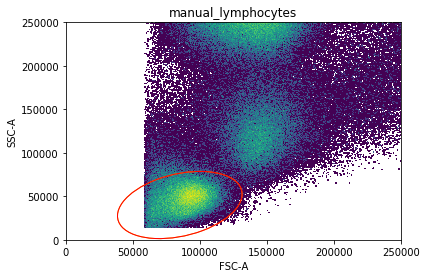

In [7]:
sep.plotting.plot_gate('manual_lymphocytes')

In [6]:
def calc_sample_frac(sep, parent):
    n = sep.get_population_df(parent).shape[0]
    frac = 0.2
    if n < 40000:
        return 0.99
    else:
        for x in [0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.12, 0.1, 0.08, 0.05, 0.03, 0.02, 0.01, 0.005, 0.001, 0.0005]:
            if n*x < 40000:
                return x

In [10]:
for x in samples:
    sep = Gating(exp, x)
    if 'dens2d_lymphocytes' in sep.populations.keys():
        continue
    print(f'Gating lymphocytes {x}...')
    parent = 'cells'
    frac = calc_sample_frac(sep, parent)
    #GMM
    try:
        child_populations = ChildPopulationCollection('geom')
        child_populations.add_population('gmm_lymphocytes', definition='+')
        child_populations.add_population('gmm_lymphocytes_NEG', definition='-')
        pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
        gate_definition = dict(x='FSC-A', y='SSC-A', target=(80000, 40000), k=3, rect_filter=pre_filter,
                              conf=0.99, transform_x=None, transform_y=None)
        sep.create_gate(gate_name='gmm_lymphocytes', parent=parent, class_='MixtureModel', method='gate',
                        kwargs=gate_definition, child_populations=child_populations)
        sep.apply('gmm_lymphocytes', plot_output=False)
    except Exception as e:
        print(f'LYMPHOCYTES GMM FAILED: {e}')
    #DBSCAN
    try:
        child_populations = ChildPopulationCollection('cluster')
        child_populations.add_population('dbscan_lymphocytes', target=(80000, 40000), weight=1)
        gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=100, distance_nn=5000, frac=frac,
                              transform_x=None, transform_y=None)
        sep.create_gate(gate_name='dbscan_lymphocytes', parent=parent, class_='DensityBasedClustering', 
                         method='dbscan', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('dbscan_lymphocytes', plot_output=False)
    except Exception as e:
        print(f'LYMPHOCYTES DBSCAN FAILED: {e}')
    #HDBSCAN
    try:
        child_populations = ChildPopulationCollection('cluster')
        child_populations.add_population('hdbscan_lymphocytes', target=(80000, 40000), weight=1)
        gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=100, frac=frac, transform_x=None, transform_y=None)
        sep.create_gate(gate_name='hdbscan_lymphocytes', parent=parent, class_='DensityBasedClustering', 
                         method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('hdbscan_lymphocytes', plot_output=False)
    except Exception as e:
        print(f'LYMPHOCYTES HDBSCAN FAILED: {e}')
    #DBSCAN
    try:
        child_populations = ChildPopulationCollection('threshold_2d')
        child_populations.add_population('dens2d_lymphocytes', definition='--')
        child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
        gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1, frac=frac)
        sep.create_gate(gate_name='dens2d_lymphocytes', parent=parent, class_='DensityThreshold', 
                         method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('dens2d_lymphocytes', plot_output=False)
    except Exception as e:
        print(f'LYMPHOCYTES DENS2D FAILED: {e}')
    sep.save(overwrite=True)


Gating lymphocytes sep17...
Saved successfully!
Gating lymphocytes sep19...
Saved successfully!
Gating lymphocytes sep28...
Saved successfully!
Gating lymphocytes sep29...
Saved successfully!
Gating lymphocytes sep34...
Saved successfully!
Gating lymphocytes sep37...
Saved successfully!
Gating lymphocytes sep38...
Saved successfully!
Gating lymphocytes sep49...
Saved successfully!
Gating lymphocytes sep50...
Saved successfully!
Gating lymphocytes sep51...
Saved successfully!
Gating lymphocytes sep67...
Saved successfully!
Gating lymphocytes sep71...
Saved successfully!


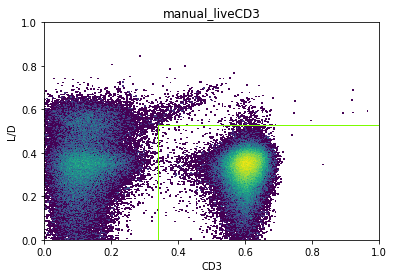

In [11]:
sep.plotting.plot_gate('manual_liveCD3')

In [12]:
for x in samples:
    sep = Gating(exp, x)
    print(f'Gating liveCD3 {x}...')
    parent = 'manual_lymphocytes'
    frac = calc_sample_frac(sep, parent)
    #GMM
    try:
        child_populations = ChildPopulationCollection('geom')
        child_populations.add_population('gmm_liveCD3', definition='+')
        child_populations.add_population('gmm_liveCD3_NEG', definition='-')
        gate_definition = dict(x='CD3', y='L/D', target=(0.6, 0.4), k=3, conf=0.99)
        sep.create_gate(gate_name='gmm_liveCD3', parent=parent, class_='MixtureModel', method='gate',
                        kwargs=gate_definition, child_populations=child_populations)
        sep.apply('gmm_liveCD3', plot_output=False)
    except Exception as e:
        print(f'GMM FAILED: {e}')
    #DBSCAN
    try:
        child_populations = ChildPopulationCollection('cluster')
        child_populations.add_population('dbscan_liveCD3', target=(0.6, 0.4), weight=1)
        gate_definition = dict(x='CD3', y='L/D', min_pop_size=100, distance_nn=0.03, frac=frac)
        sep.create_gate(gate_name='dbscan_liveCD3', parent=parent, class_='DensityBasedClustering', 
                         method='dbscan', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('dbscan_liveCD3', plot_output=False)
    except Exception as e:
        print(f'DBSCAN FAILED: {e}')
    #HDBSCAN
    try:
        child_populations = ChildPopulationCollection('cluster')
        child_populations.add_population('hdbscan_liveCD3', target=(0.6, 0.4), weight=1)
        gate_definition = dict(x='CD3', y='L/D', min_pop_size=100, frac=frac)
        sep.create_gate(gate_name='hdbscan_liveCD3', parent=parent, class_='DensityBasedClustering', 
                         method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('hdbscan_liveCD3', plot_output=False)
    except Exception as e:
        print(f'HDBSCAN FAILED: {e}')
    #DENS2D
    try:
        child_populations = ChildPopulationCollection('threshold_2d')
        child_populations.add_population('dens2d_liveCD3', definition='+-')
        child_populations.add_population('dens2d_dead', definition=['++', '--', '-+'])
        gate_definition = dict(x='CD3', y='L/D', kde_bw=0.1, frac=frac)
        sep.create_gate(gate_name='dens2d_liveCD3', parent='manual_lymphocytes', class_='DensityThreshold', 
                         method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('dens2d_liveCD3', plot_output=False)
    except Exception as e:
        print(f'DENS2D FAILED: {e}')
    sep.save(overwrite=True)

Gating liveCD3 sep6...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep13...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep17...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep19...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep28...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep29...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep34...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep37...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep38...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep49...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep50...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep51...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep67...
DENS2D FAILED: None
Saved successfully!
Gating liveCD3 sep71...
DENS2D FAILED: None
Saved successfully!


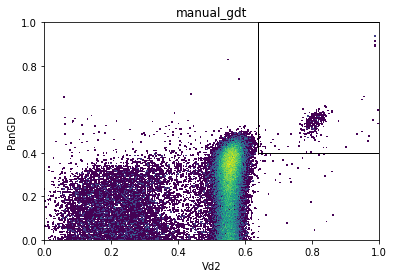

In [13]:
sep.plotting.plot_gate('manual_gdt')

In [14]:
for x in samples:
    sep = Gating(exp, x)
    print(f'Gating GDT {x}...')
    parent = 'manual_liveCD3'
    frac = calc_sample_frac(sep, parent)
    #GMM
    try:
        child_populations = ChildPopulationCollection('geom')
        child_populations.add_population('gmm_gdt', definition='+')
        child_populations.add_population('gmm_nongdt', definition='-')
        gate_definition = dict(x='Vd2', y='PanGD', target=(0.7, 0.5), k=2, conf=0.99)
        sep.create_gate(gate_name='gmm_gdt', parent=parent, class_='MixtureModel', method='gate',
                        kwargs=gate_definition, child_populations=child_populations)
        sep.apply('gmm_gdt', plot_output=False)
    except Exception as e:
        print(f'GMM FAILED: {e}')
    #DBSCAN
    try:
        child_populations = ChildPopulationCollection('cluster')
        child_populations.add_population('dbscan_gdt', target=(0.7, 0.5), weight=1)
        child_populations.add_population('dbscan_nongdt', target=(0.2, 0.2), weight=1)
        gate_definition = dict(x='Vd2', y='PanGD', min_pop_size=50, distance_nn=0.03, frac=frac, downsample_method='density')
        sep.create_gate(gate_name='dbscan_gdt', parent=parent, class_='DensityBasedClustering', 
                         method='dbscan', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('dbscan_gdt', plot_output=False)
    except Exception as e:
        print(f'DBSCAN FAILED: {e}')
    #HDBSCAN
    try:
        child_populations = ChildPopulationCollection('cluster')
        child_populations.add_population('hdbscan_gdt', target=(0.7, 0.5), weight=1)
        child_populations.add_population('hdbscan_nongdt', target=(0.2, 0.2), weight=1)
        gate_definition = dict(x='Vd2', y='PanGD', min_pop_size=50, frac=frac, downsample_method='density')
        sep.create_gate(gate_name='hdbscan_gdt', parent=parent, class_='DensityBasedClustering', 
                         method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('dbscan_gdt', plot_output=False)
    except Exception as e:
        print(f'HDBSCAN FAILED: {e}')
    #DBSCAN
    try:
        child_populations = ChildPopulationCollection('threshold_2d')
        child_populations.add_population('dens2d_gdt', definition='-+')
        child_populations.add_population('dens2d_nongdt', definition=['++', '+-', '-+'])
        gate_definition = dict(x='Vd2', y='PanGD', kde_bw=0.1, frac=frac)
        sep.create_gate(gate_name='dens2d_gdt', parent=parent, class_='DensityThreshold', 
                         method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('dens2d_gdt', plot_output=False)
    except Exception as e:
        print(f'DENS2D FAILED: {e}')
    sep.save(overwrite=True)

Gating GDT sep6...
Error: population dbscan_gdt already exists, if you wish to overwrite this population please remove it with the remove_population method and then try again
DENS2D FAILED: None
Saved successfully!
Gating GDT sep13...
Error: population dbscan_gdt already exists, if you wish to overwrite this population please remove it with the remove_population method and then try again
DENS2D FAILED: None
Saved successfully!
Gating GDT sep17...
Error: population dbscan_gdt already exists, if you wish to overwrite this population please remove it with the remove_population method and then try again
DENS2D FAILED: None
Saved successfully!
Gating GDT sep19...
Error: population dbscan_gdt already exists, if you wish to overwrite this population please remove it with the remove_population method and then try again
DENS2D FAILED: None
Saved successfully!
Gating GDT sep28...
Error: population dbscan_gdt already exists, if you wish to overwrite this population please remove it with the remov

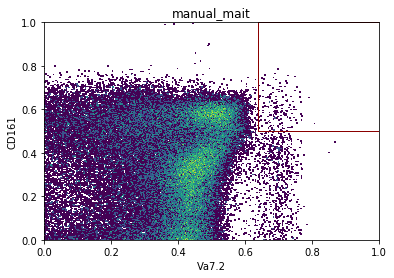

In [15]:
sep.plotting.plot_gate('manual_mait')

In [16]:
for x in samples:
    sep = Gating(exp, x)
    print(f'Gating MAITs {x}...')
    parent = 'manual_nongdt'
    frac = calc_sample_frac(sep, parent)
    #GMM
    try:
        child_populations = ChildPopulationCollection('geom')
        child_populations.add_population('gmm_mait', definition='+')
        child_populations.add_population('gmm_classic', definition='-')
        pre_filter = dict(xmin=0.4, xmax=1, ymin=0.4, ymax=1)
        gate_definition = dict(x='Va7.2', y='CD161', target=(0.7, 0.7), k=3, conf=0.99, rect_filter=pre_filter)
        sep.create_gate(gate_name='gmm_mait', parent='manual_nongdt',  class_='MixtureModel', method='gate',
                        kwargs=gate_definition, child_populations=child_populations)
        sep.apply('gmm_mait', plot_output=False)
    except Exception as e:
        print(f'GMM FAILED: {e}')
    #DBSCAN
    try:
        child_populations = ChildPopulationCollection('cluster')
        child_populations.add_population('dbscan_mait', target=(0.7, 0.7), weight=1)
        child_populations.add_population('dbscan_classic', target=(0.4, 0.4), weight=1)
        gate_definition = dict(x='Va7.2', y='CD161', min_pop_size=10, distance_nn=0.03, frac=frac, downsample_method='density')
        sep.create_gate(gate_name='dbscan_mait', parent='manual_nongdt', class_='DensityBasedClustering', 
                         method='dbscan', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('dbscan_mait', plot_output=False)
    except Exception as e:
        print(f'DBSCAN FAILED: {e}')
    #HDBSCAN
    try:
        child_populations = ChildPopulationCollection('cluster')
        child_populations.add_population('hdbscan_mait', target=(0.7, 0.7), weight=1)
        child_populations.add_population('hdbscan_classic', target=(0.4, 0.4), weight=1)
        gate_definition = dict(x='Va7.2', y='CD161', min_pop_size=10, frac=frac, downsample_method='density')
        sep.create_gate(gate_name='hdbscan_mait', parent='manual_nongdt', class_='DensityBasedClustering', 
                         method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('hdbscan_mait', plot_output=False)
    except Exception as e:
        print(f'HDBSCAN FAILED: {e}')
    #DBSCAN
    try:
        child_populations = ChildPopulationCollection('threshold_2d')
        child_populations.add_population('dens2d_mait', definition='-+')
        child_populations.add_population('dens2d_classic', definition=['++', '+-', '-+'])
        gate_definition = dict(x='Va7.2', y='CD161', kde_bw=0.2, frac=frac)
        sep.create_gate(gate_name='dens2d_mait', parent='manual_nongdt', class_='DensityThreshold', 
                         method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('dens2d_mait', plot_output=False)
    except Exception as e:
        print(f'DENS2D FAILED: {e}')
    sep.save(overwrite=True)

Gating MAITs sep6...
DENS2D FAILED: None
Saved successfully!
Gating MAITs sep13...
Expected 2 populations but found 1
Populations f['dbscan_mait', 'dbscan_classic'] assigned to the same cluster 0;prioritising dbscan_mait based on weighting.
DENS2D FAILED: None
Saved successfully!
Gating MAITs sep17...
DENS2D FAILED: None
Saved successfully!
Gating MAITs sep19...
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
DENS2D FAILED: None
Saved successfully!
Gating MAITs sep28...
DENS2D FAILED: None
Saved successfully!
Gating MAITs sep29...
Expected 2 populations but found 1
Populations f['dbscan_mait', 'dbscan_classic'] assigned to the same cluster 0;prioritising dbscan_mait based on weighting.
DENS2D FAILED: None
Saved successfully!
Gating MAITs sep34...
Expected 2 populations but found 1
Populations f['dbscan_mait', 'dbscan_classic'] assigned to the same cluster 0;prioritising dbscan_mait based on weighting.
Expected 2 populations but foun

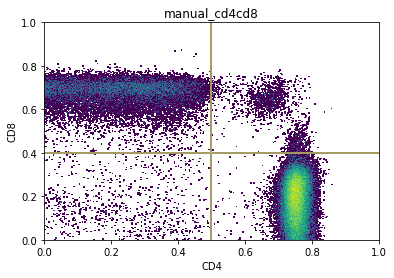

In [17]:
sep.plotting.plot_gate('manual_cd4cd8')

In [18]:
for x in samples:
    sep = Gating(exp, x)
    print(f'Gating CD4 CD8 {x}...')
    parent = 'manual_classic'
    frac = calc_sample_frac(sep, parent)
    #GMM
    try:
        child_populations = ChildPopulationCollection('geom')
        child_populations.add_population('gmm_cd4', definition='+')
        child_populations.add_population('gmm_notcd4', definition='-')
        gate_definition = dict(x='CD4', y='CD8', target=(0.7, 0.2), k=3, conf=0.99)
        sep.create_gate(gate_name='gmm_cd4', parent='manual_classic',  class_='MixtureModel', method='gate',
                        kwargs=gate_definition, child_populations=child_populations)
        sep.apply('gmm_cd4', plot_output=False)
        
        child_populations = ChildPopulationCollection('geom')
        child_populations.add_population('gmm_cd8', definition='+')
        child_populations.add_population('gmm_notcd8', definition='-')
        gate_definition = dict(x='CD4', y='CD8', target=(0.2, 0.7), k=3, conf=0.99)
        sep.create_gate(gate_name='gmm_cd8', parent='manual_classic',  class_='MixtureModel', method='gate',
                        kwargs=gate_definition, child_populations=child_populations)
        sep.apply('gmm_cd8', plot_output=False)
    except Exception as e:
        print(f'GMM FAILED: {e}')
    #DBSCAN
    try:
        child_populations = ChildPopulationCollection('cluster')
        child_populations.add_population('dbscan_cd4', target=(0.7, 0.2), weight=1)
        child_populations.add_population('dbscan_cd8', target=(0.2, 0.7), weight=1)
        gate_definition = dict(x='CD4', y='CD8', min_pop_size=100, distance_nn=0.03, frac=frac, downsample_method='density')
        sep.create_gate(gate_name='dbscan_cd4cd8', parent='manual_classic', class_='DensityBasedClustering', 
                         method='dbscan', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('dbscan_cd4cd8', plot_output=False)
    except Exception as e:
        print(f'DBSCAN FAILED: {e}')
    #HDBSCAN
    try:
        child_populations = ChildPopulationCollection('cluster')
        child_populations.add_population('hdbscan_cd4', target=(0.7, 0.2), weight=1)
        child_populations.add_population('hdbscan_cd8', target=(0.2, 0.7), weight=1)
        gate_definition = dict(x='CD4', y='CD8', min_pop_size=100, frac=frac, downsample_method='density')
        sep.create_gate(gate_name='hdbscan_cd4cd8', parent='manual_classic', class_='DensityBasedClustering', 
                         method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('hdbscan_cd4cd8', plot_output=False)
    except Exception as e:
        print(f'HDBSCAN FAILED: {e}')
    #DBSCAN
    try:
        child_populations = ChildPopulationCollection('threshold_2d')
        child_populations.add_population('dens2d_cd4', definition=['+-'])
        child_populations.add_population('dens2d_cd8', definition=['-+'])
        child_populations.add_population('dens2d_notcd4cd8', definition=['++', '--'])
        gate_definition = dict(x='CD4', y='CD8', kde_bw=0.05, frac=frac)
        sep.create_gate(gate_name='dens2d_cd4cd8', parent='manual_classic', class_='DensityThreshold', 
                         method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
        sep.apply('dens2d_cd4cd8', plot_output=False)
    except Exception as e:
        print(f'DENS2D FAILED: {e}')
    sep.save(overwrite=True)

Gating CD4 CD8 sep6...
Error: gmm_cd4 does not exist. You must create this gate first using the create_gate method
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Expected 2 populations but found 1
Populations f['dbscan_cd4', 'dbscan_cd8'] assigned to the same cluster 0;prioritising dbscan_cd4 based on weighting.
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Invalid definition +-, must be one of [++, --, -+, +-]
DENS2D FAILED: Aborting; invalid child population construct
Saved successfully!
Gating CD4 CD8 sep13...
Error: gmm_cd4 does not exist. You must create this gate first using the create_gate method
Invalid definition +-, must be one of [++, --, -+, +-]
DENS2D FAILED: Aborting; invalid child population construct
Saved successfully!
Gating CD4 CD8 sep17...
Error: gmm_cd4 does not exist. You must create this gate first using the create_gate method
Error: density dependendent

<h1>Corrections</h1>

<h3>LiveCD3</h3>

In [28]:
for x in samples:
    sep = Gating(exp, x)
    if 'dens2d_liveCD3' in sep.gates.keys():
        sep.gates.pop('dens2d_liveCD3')
    frac = calc_sample_frac(sep, 'manual_lymphocytes')
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_liveCD3', definition='-+')
    child_populations.add_population('dens2d_dead', definition=['++', '--', '+-'])
    gate_definition = dict(x='CD3', y='L/D', kde_bw=0.1, frac=frac)
    sep.create_gate(gate_name='dens2d_liveCD3', parent='manual_lymphocytes', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    sep.apply('dens2d_liveCD3', plot_output=False)
    sep.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


<h3>GDT</h3>

In [29]:
for x in samples:
    sep = Gating(exp, x)
    remove_pops = ['dbscan_gdt', 'dbscan_nongdt', 'dens2d_gdt', 'dens2d_nongdt']
    remove_gate = ['dbscan_gdt', 'dens2d_gdt']
    for p in remove_pops:
        if p in sep.populations.keys():
            sep.populations.pop(p)
    for g in remove_gate:
        if g in sep.gates.keys():
            sep.gates.pop(g)

    parent = 'manual_liveCD3'
    frac = calc_sample_frac(sep, parent)
        
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_gdt', target=(0.7, 0.5), weight=1)
    child_populations.add_population('dbscan_nongdt', target=(0.2, 0.2), weight=1)
    gate_definition = dict(x='Vd2', y='PanGD', min_pop_size=50, distance_nn=0.03, frac=frac, downsample_method='density')
    sep.create_gate(gate_name='dbscan_gdt', parent=parent, class_='DensityBasedClustering', 
                     method='dbscan', kwargs=gate_definition, child_populations=child_populations)
    sep.apply('dbscan_gdt', plot_output=False)

    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_gdt', definition='-+')
    child_populations.add_population('dens2d_nongdt', definition=['++', '+-', '--'])
    gate_definition = dict(x='Vd2', y='PanGD', kde_bw=0.1, frac=frac)
    sep.create_gate(gate_name='dens2d_gdt', parent=parent, class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    sep.apply('dens2d_gdt', plot_output=False)
    sep.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Expected 2 populations but found 1
Populations f['dbscan_gdt', 'dbscan_nongdt'] assigned to the same cluster 0;prioritising dbscan_gdt based on weighting.
Saved successfully!
Saved successfully!
Saved successfully!
Expected 2 populations but found 1
Populations f['dbscan_gdt', 'dbscan_nongdt'] assigned to the same cluster 0;prioritising dbscan_gdt based on weighting.
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Expected 2 populations but found 1
Populations f['dbscan_gdt', 'dbscan_nongdt'] assigned to the same cluster 0;prioritising dbscan_gdt based on weighting.
Saved successfully!


<h3>MAIT</h3>

In [32]:
for x in samples:
    sep = Gating(exp, x)
    remove_pops = ['dens2d_mait', 'dens2d_classic']
    remove_gate = ['dens2d_mait']
    for p in remove_pops:
        if p in sep.populations.keys():
            sep.populations.pop(p)
    for g in remove_gate:
        if g in sep.gates.keys():
            sep.gates.pop(g)
            
    parent = 'manual_nongdt'
    frac = calc_sample_frac(sep, parent)

    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_mait', definition='-+')
    child_populations.add_population('dens2d_classic', definition=['++', '+-', '--'])
    gate_definition = dict(x='Vd2', y='PanGD', kde_bw=0.1, frac=frac)
    sep.create_gate(gate_name='dens2d_mait', parent=parent, class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    sep.apply('dens2d_mait', plot_output=False)
    sep.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


<h3>CD4 CD8</h3>

In [31]:
for x in samples:
    sep = Gating(exp, x)
    remove_pops = ['gmm_cd4', 'dens2d_cd4', 'dens2d_cd8', 'dens2d_notcd4cd8']
    remove_gate = ['dens2d_cd4cd8', 'gmm_cd4']
    for p in remove_pops:
        if p in sep.populations.keys():
            sep.populations.pop(p)
    for g in remove_gate:
        if g in sep.gates.keys():
            sep.gates.pop(g)
            
    parent = 'manual_classic'
    frac = calc_sample_frac(sep, parent)
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_cd4', definition='+')
    child_populations.add_population('gmm_notcd4', definition='-')
    gate_definition = dict(x='CD4', y='CD8', target=(0.7, 0.2), k=3, conf=0.99)
    sep.create_gate(gate_name='gmm_cd4', parent='manual_classic',  class_='MixtureModel', method='gate',
                    kwargs=gate_definition, child_populations=child_populations)
    sep.apply('gmm_cd4', plot_output=False)
    
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_cd4', definition=['+-'])
    child_populations.add_population('dens2d_cd8', definition=['-+'])
    child_populations.add_population('dens2d_notcd4cd8', definition=['++', '--'])
    gate_definition = dict(x='CD4', y='CD8', kde_bw=0.05, frac=frac)
    sep.create_gate(gate_name='dens2d_cd4cd8', parent='manual_classic', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    sep.apply('dens2d_cd4cd8', plot_output=False)
    sep.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [10]:
for x in samples:
    sep = Gating(exp, x)
    remove_pops = ['hdbscan_gdt', 'hdbscan_nongdt']
    remove_gate = ['hdbscan_gdt']
    for p in remove_pops:
        if p in sep.populations.keys():
            sep.populations.pop(p)
    for g in remove_gate:
        if g in sep.gates.keys():
            sep.gates.pop(g)

    parent = 'manual_liveCD3'
    frac = calc_sample_frac(sep, parent)
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_gdt', target=(0.7, 0.5), weight=1)
    child_populations.add_population('hdbscan_nongdt', target=(0.2, 0.2), weight=1)
    gate_definition = dict(x='Vd2', y='PanGD', min_pop_size=10, frac=frac, downsample_method='density')
    sep.create_gate(gate_name='hdbscan_gdt', parent=parent, class_='DensityBasedClustering', 
                     method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    sep.apply('hdbscan_gdt', plot_output=False)
    sep.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Saved successfully!
